<a href="https://colab.research.google.com/github/SepideHematian/NLP_690_course/blob/main/Homework/Tahereh_Hematian_HW4_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Exercise 1

1. Import the required libraries.

In [ ]:
import nltk
nltk.download('all')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from string import punctuation
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, KFold

2. Load the dataset containing a set of 1,000 product reviews from Amazon, which are paired with a label of 0 (for negative reviews) or 1 (for positive reviews). Get the data at https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

In [ ]:
# reading zip files
from zipfile import ZipFile

with ZipFile('/content/sentiment labelled sentences.zip', mode = 'r') as file:
  file.extractall(path = '/content/')

In [ ]:
colnames=['review', 'sentiment'] 
amazon_labelled = pd.read_csv('/content/sentiment labelled sentences/amazon_cells_labelled.txt', sep='\t',
                             names=colnames, header=None )
# imdb_labelled = pd.read_csv('/content/sentiment labelled sentences/imdb_labelled.txt', sep='\t')
# yelp_labelled = pd.read_csv('/content/sentiment labelled sentences/yelp_labelled.txt', sep='\t')

# test = pd.read_csv("/content/test.tsv", sep='\t')

# converting labels to string
# train['Sentiment'] = train['Sentiment'].apply(str)

In [ ]:
amazon_labelled

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


3. Separate the data into two variables: one containing the reviews and the other containing the labels. Remove the punctuation from the reviews.

In [ ]:
def split_words_reviews(data):
    text = list(data['review'].values)
    clean_text = []
    for t in text:
        clean_text.append(t.translate(str.maketrans('', '', punctuation)).lower().rstrip())
    # print(clean_text)
    tokenized = [word_tokenize(x) for x in clean_text]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

reviews, vocab = split_words_reviews(amazon_labelled)

reviews[0]

['so',
 'there',
 'is',
 'no',
 'way',
 'for',
 'me',
 'to',
 'plug',
 'it',
 'in',
 'here',
 'in',
 'the',
 'us',
 'unless',
 'i',
 'go',
 'by',
 'a',
 'converter']

4. Create a variable containing the vocabulary of the entire set of reviews.
5. Additionally, create a dictionary that maps each word to an integer, where the words will be the keys and the integers will be the values.

In [ ]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i, w in enumerate(words)}
    int_to_word_dict = {i:w for w, i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict

word_to_int_dict, int_to_word_dict = create_dictionaries(vocab)

word_to_int_dict

{'graphics': 1,
 'minutesmajor': 2,
 'hour': 3,
 'fry': 4,
 'ugly': 5,
 'upbeat': 6,
 'place': 7,
 'leopard': 8,
 'forced': 9,
 'trouble': 10,
 '20': 11,
 'exceptional': 12,
 'gosh': 13,
 'breaks': 14,
 'reading': 15,
 'lightly': 16,
 'odd': 17,
 'distracting': 18,
 'anything': 19,
 'five': 20,
 'never': 21,
 'idea': 22,
 'intended': 23,
 'lit': 24,
 'hinge': 25,
 'disgusting': 26,
 'support': 27,
 'dna': 28,
 'texas': 29,
 'roles': 30,
 'broke': 31,
 'converter': 32,
 'h500': 33,
 'thanks': 34,
 'activated': 35,
 'costs': 36,
 'faceplates': 37,
 'expected': 38,
 'lights': 39,
 'na': 40,
 'four': 41,
 'abovepretty': 42,
 'noticed': 43,
 'walkman': 44,
 'edge': 45,
 'utter': 46,
 'wooden': 47,
 'performing': 48,
 'kindle': 49,
 'build': 50,
 'sound': 51,
 'an': 52,
 'buying': 53,
 'complained': 54,
 'earset': 55,
 'hand': 56,
 'charge': 57,
 'anywhere': 58,
 'decade': 59,
 'construction': 60,
 'monkeys': 61,
 'keeping': 62,
 'oozes': 63,
 'consumer': 64,
 'or': 65,
 'none': 66,
 'mentio

6. Encode the reviews data by replacing each word in a review for its paired integer.

In [ ]:
def pad_text(tokenized_reviews, seq_length):
    
    reviews = []
    
    for review in tokenized_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append(['']*(seq_length-len(review)) + review)
        
    return np.array(reviews)

padded_sentences = pad_text(reviews, seq_length = 50)

padded_sentences[0]

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', 'so', 'there',
       'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here',
       'in', 'the', 'us', 'unless', 'i', 'go', 'by', 'a', 'converter'],
      dtype='<U22')

In [ ]:
int_to_word_dict[0] = ''
word_to_int_dict[''] = 0

encoded_sentences = np.array([[word_to_int_dict[word] for word in review] for review in padded_sentences])

encoded_sentences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1367, 1892, 1570,  468,
        928, 1467,  107,  648,  504,  109, 1140, 1342, 1140,  994, 1655,
        945, 1665,  222,  271,  632,   32])

7. Create a class containing the architecture of the network.


In [ ]:
class SentimentLSTM(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.8):
        super().__init__()
        
        self.n_vocab = n_vocab  
        self.n_layers = n_layers 
        self.n_hidden = n_hidden 
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward (self, input_words):
                          
        embedded_words = self.embedding(input_words)
        lstm_out, h = self.lstm(embedded_words) 
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden)
        fc_out = self.fc(lstm_out)                  
        sigmoid_out = self.sigmoid(fc_out)              
        sigmoid_out = sigmoid_out.view(batch_size, -1)  
        
        sigmoid_last = sigmoid_out[:, -1]
        
        return sigmoid_last, h
    
    
    def init_hidden (self, batch_size):
        
        device = "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

8. Make sure that you include an embedding layer. Initialize the model using 64 embedding dimensions and 128 neurons for 3 LSTM layers.

In [ ]:
n_vocab = len(word_to_int_dict)
n_embed = 64
n_hidden = 128
n_output = 1
n_layers = 3

net = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)

9. Define the loss function, an optimization algorithm, and the number of epochs to train for. For example, you can use binary cross-entropy loss as the loss function, the Adam optimizer, and train for 10 epochs.

In [ ]:
labels = np.array([int(x) for x in amazon_labelled['sentiment'].values])


train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2

total = len(encoded_sentences)
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))

train_x, train_y = torch.Tensor(encoded_sentences[:train_cutoff]).long(), torch.Tensor(labels[:train_cutoff]).long()
valid_x, valid_y = torch.Tensor(encoded_sentences[train_cutoff : valid_cutoff]).long(), torch.Tensor(labels[train_cutoff : valid_cutoff]).long()
test_x, test_y = torch.Tensor(encoded_sentences[valid_cutoff:]).long(), torch.Tensor(labels[valid_cutoff:])

train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

batch_size = 2

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
print_every = 2400
step = 0
n_epochs = 3
clip = 5  
criterion = nn.BCELoss()
# net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)

10. Create a for loop that goes through the different epochs and through every single review individually. For each review, perform a prediction, calculate the loss function, and update the parameters of the network. Additionally, calculate the accuracy of the network over that training data.

In [ ]:
loss_lst = []
for epoch in range(n_epochs):
  h = net.init_hidden(batch_size)

  for inputs, labels in train_loader:
    step += 1  
    net.zero_grad()
    output, h = net(inputs)
    loss = criterion(output.squeeze(), labels.float())
    loss_lst.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm(net.parameters(), clip)
    optimizer.step()

    if (step % print_every) == 0:            
      net.eval()
      valid_losses = []

      for v_inputs, v_labels in valid_loader:
            
        v_output, v_h = net(v_inputs)
        v_loss = criterion(v_output.squeeze(), v_labels.float())
        valid_losses.append(v_loss.item())

  print("Epoch: {}/{}".format((epoch+1), n_epochs),
  "Step: {}".format(step),
  "Training Loss: {:.4f}".format(loss.item()),
  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
  net.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if sys.path[0] == '':


Epoch: 1/3 Step: 4800 Training Loss: 0.0001 Validation Loss: 1.6321
Epoch: 2/3 Step: 5200 Training Loss: 0.0001 Validation Loss: 1.6321
Epoch: 3/3 Step: 5600 Training Loss: 0.0002 Validation Loss: 1.6321


11. Plot the progress of the loss function and accuracy over time.

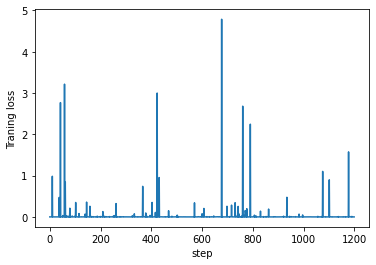

In [ ]:
plt.plot(range(len(loss_lst)), loss_lst)
plt.xlabel('step')
plt.ylabel('Traning loss');

In [ ]:
net.eval()
test_losses = []
num_correct = 0

for inputs, labels in test_loader:

    test_output, test_h = net(inputs)
    loss = criterion(test_output, labels)
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))    

Test Loss: 2.5067
Test Accuracy: 0.71


In [ ]:
def preprocess_review(review):
    review = review.translate(str.maketrans('', '', punctuation)).lower().rstrip()
    tokenized = word_tokenize(review)
    if len(tokenized) >= 50:
        review = tokenized[:50]
    else:
        review= ['0']*(50-len(tokenized)) + tokenized
    
    final = []
    
    for token in review:
        try:
            final.append(word_to_int_dict[token])
            
        except:
            final.append(word_to_int_dict[''])
        
    return final

In [ ]:
def predict(review):
    net.eval()
    words = np.array([preprocess_review(review)])
    padded_words = torch.from_numpy(words)
    pred_loader = DataLoader(padded_words, batch_size = 1, shuffle = True)
    for x in pred_loader:
        output = net(x)[0].item()
    
    msg = "This is a positive review." if output >= 0.5 else "This is a negative review."
    print(msg)
    print('Prediction = ' + str(output))

## Exercise 2. Sentiment Analysis

In [ ]:
sentence = "The larger Broncos will be available with 35-inch off-road tires and will be able to drive through water nearly 3 feet, 10 inches deep. It has independent frontsuspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used on almost all modern passenger vehicles, generally provides a smoother ride and better on-road handling than a single solid axle. It still has a solid axle in the back though, like most pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available with a choice of either a 10-speed automatic or seven-speed manual transmission. (The manual transmission will have six gears for ordinary driving, plus a seventh for low speed off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its capabilities. It also has more convenience features than the more truck-like Bronco. While it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still intended for serious off-road use. Ford engineers boasted of the off-road testing the prototypes have been put through, including driving through deep sand, up steep inclines and crawling across boulder-strewn trails."

1. Replace special characters with empty spaces. You can use regex or any other method

In [ ]:
import re
text = re.sub("[^A-Za-z]+", " ", sentence)
text

'The larger Broncos will be available with inch off road tires and will be able to drive through water nearly feet inches deep It has independent frontsuspension unlike its main competitor the Jeep Wrangler Independent suspension used on almost all modern passenger vehicles generally provides a smoother ride and better on road handling than a single solid axle It still has a solid axle in the back though like most pickup trucks a design suited to hard use Like the Wrangler both the two and four door Bronco will have a removable roofs and doors Buyers will be able to choose either a hard roof that can be removed in sections a cloth top or both Unlike the Wrangler though the Bronco s doors will fit inside the vehicle after being removed The Bronco will be available with a choice of either a speed automatic or seven speed manual transmission The manual transmission will have six gears for ordinary driving plus a seventh for low speed off road driving It will be powered by either a horsepo

2. Remove multiple empty spaces and replace them by a single space

In [ ]:
result = re.sub(' +', ' ', text)
result

'The larger Broncos will be available with inch off road tires and will be able to drive through water nearly feet inches deep It has independent frontsuspension unlike its main competitor the Jeep Wrangler Independent suspension used on almost all modern passenger vehicles generally provides a smoother ride and better on road handling than a single solid axle It still has a solid axle in the back though like most pickup trucks a design suited to hard use Like the Wrangler both the two and four door Bronco will have a removable roofs and doors Buyers will be able to choose either a hard roof that can be removed in sections a cloth top or both Unlike the Wrangler though the Bronco s doors will fit inside the vehicle after being removed The Bronco will be available with a choice of either a speed automatic or seven speed manual transmission The manual transmission will have six gears for ordinary driving plus a seventh for low speed off road driving It will be powered by either a horsepo

3. Remove any single character

In [ ]:
clean_text = re.sub('\s*\\b([a-z]|[a-z]{2})\\b', '', result)
clean_text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', clean_text)
clean_text

'The larger Broncos will available with inch off road tires and will able drive through water nearly feet inches deep It has independent frontsuspension unlike its main competitor the Jeep Wrangler Independent suspension used almost all modern passenger vehicles generally provides smoother ride and better road handling than single solid axle It still has solid axle the back though like most pickup trucks design suited hard use Like the Wrangler both the two and four door Bronco will have removable roofs and doors Buyers will able choose either hard roof that can removed sections cloth top both Unlike the Wrangler though the Bronco doors will fit inside the vehicle after being removed The Bronco will available with choice either speed automatic seven speed manual transmission The manual transmission will have six gears for ordinary driving plus seventh for low speed off road driving It will powered either horsepower liter turbocharged cylinder engine horsepower liter turbocharged While 

4. Convert the text to all lower case

In [ ]:
clean_text_lower = clean_text.lower()
clean_text_lower

'the larger broncos will available with inch off road tires and will able drive through water nearly feet inches deep it has independent frontsuspension unlike its main competitor the jeep wrangler independent suspension used almost all modern passenger vehicles generally provides smoother ride and better road handling than single solid axle it still has solid axle the back though like most pickup trucks design suited hard use like the wrangler both the two and four door bronco will have removable roofs and doors buyers will able choose either hard roof that can removed sections cloth top both unlike the wrangler though the bronco doors will fit inside the vehicle after being removed the bronco will available with choice either speed automatic seven speed manual transmission the manual transmission will have six gears for ordinary driving plus seventh for low speed off road driving it will powered either horsepower liter turbocharged cylinder engine horsepower liter turbocharged while 

5. Split the text to individual words

In [ ]:
words = [x for x in clean_text_lower.split(' ')]
words

['the',
 'larger',
 'broncos',
 'will',
 'available',
 'with',
 'inch',
 'off',
 'road',
 'tires',
 'and',
 'will',
 'able',
 'drive',
 'through',
 'water',
 'nearly',
 'feet',
 'inches',
 'deep',
 'it',
 'has',
 'independent',
 'frontsuspension',
 'unlike',
 'its',
 'main',
 'competitor',
 'the',
 'jeep',
 'wrangler',
 'independent',
 'suspension',
 'used',
 'almost',
 'all',
 'modern',
 'passenger',
 'vehicles',
 'generally',
 'provides',
 'smoother',
 'ride',
 'and',
 'better',
 'road',
 'handling',
 'than',
 'single',
 'solid',
 'axle',
 'it',
 'still',
 'has',
 'solid',
 'axle',
 'the',
 'back',
 'though',
 'like',
 'most',
 'pickup',
 'trucks',
 'design',
 'suited',
 'hard',
 'use',
 'like',
 'the',
 'wrangler',
 'both',
 'the',
 'two',
 'and',
 'four',
 'door',
 'bronco',
 'will',
 'have',
 'removable',
 'roofs',
 'and',
 'doors',
 'buyers',
 'will',
 'able',
 'choose',
 'either',
 'hard',
 'roof',
 'that',
 'can',
 'removed',
 'sections',
 'cloth',
 'top',
 'both',
 'unlike',
 

6. Remove stopwords

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
words_no_stop = [word for word in words if word not in stop]
words_no_stop

['larger',
 'broncos',
 'available',
 'inch',
 'road',
 'tires',
 'able',
 'drive',
 'water',
 'nearly',
 'feet',
 'inches',
 'deep',
 'independent',
 'frontsuspension',
 'unlike',
 'main',
 'competitor',
 'jeep',
 'wrangler',
 'independent',
 'suspension',
 'used',
 'almost',
 'modern',
 'passenger',
 'vehicles',
 'generally',
 'provides',
 'smoother',
 'ride',
 'better',
 'road',
 'handling',
 'single',
 'solid',
 'axle',
 'still',
 'solid',
 'axle',
 'back',
 'though',
 'like',
 'pickup',
 'trucks',
 'design',
 'suited',
 'hard',
 'use',
 'like',
 'wrangler',
 'two',
 'four',
 'door',
 'bronco',
 'removable',
 'roofs',
 'doors',
 'buyers',
 'able',
 'choose',
 'either',
 'hard',
 'roof',
 'removed',
 'sections',
 'cloth',
 'top',
 'unlike',
 'wrangler',
 'though',
 'bronco',
 'doors',
 'fit',
 'inside',
 'vehicle',
 'removed',
 'bronco',
 'available',
 'choice',
 'either',
 'speed',
 'automatic',
 'seven',
 'speed',
 'manual',
 'transmission',
 'manual',
 'transmission',
 'six',
 'g

7. Tokenize, stem, and lemmatize the text

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
tokens = [ word_tokenize(token) for token in words_no_stop]
tokens

[['larger'],
 ['broncos'],
 ['available'],
 ['inch'],
 ['road'],
 ['tires'],
 ['able'],
 ['drive'],
 ['water'],
 ['nearly'],
 ['feet'],
 ['inches'],
 ['deep'],
 ['independent'],
 ['frontsuspension'],
 ['unlike'],
 ['main'],
 ['competitor'],
 ['jeep'],
 ['wrangler'],
 ['independent'],
 ['suspension'],
 ['used'],
 ['almost'],
 ['modern'],
 ['passenger'],
 ['vehicles'],
 ['generally'],
 ['provides'],
 ['smoother'],
 ['ride'],
 ['better'],
 ['road'],
 ['handling'],
 ['single'],
 ['solid'],
 ['axle'],
 ['still'],
 ['solid'],
 ['axle'],
 ['back'],
 ['though'],
 ['like'],
 ['pickup'],
 ['trucks'],
 ['design'],
 ['suited'],
 ['hard'],
 ['use'],
 ['like'],
 ['wrangler'],
 ['two'],
 ['four'],
 ['door'],
 ['bronco'],
 ['removable'],
 ['roofs'],
 ['doors'],
 ['buyers'],
 ['able'],
 ['choose'],
 ['either'],
 ['hard'],
 ['roof'],
 ['removed'],
 ['sections'],
 ['cloth'],
 ['top'],
 ['unlike'],
 ['wrangler'],
 ['though'],
 ['bronco'],
 ['doors'],
 ['fit'],
 ['inside'],
 ['vehicle'],
 ['removed'],
 ['b

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
[ps.stem(word) for word in words_no_stop]

['larger',
 'bronco',
 'avail',
 'inch',
 'road',
 'tire',
 'abl',
 'drive',
 'water',
 'nearli',
 'feet',
 'inch',
 'deep',
 'independ',
 'frontsuspens',
 'unlik',
 'main',
 'competitor',
 'jeep',
 'wrangler',
 'independ',
 'suspens',
 'use',
 'almost',
 'modern',
 'passeng',
 'vehicl',
 'gener',
 'provid',
 'smoother',
 'ride',
 'better',
 'road',
 'handl',
 'singl',
 'solid',
 'axl',
 'still',
 'solid',
 'axl',
 'back',
 'though',
 'like',
 'pickup',
 'truck',
 'design',
 'suit',
 'hard',
 'use',
 'like',
 'wrangler',
 'two',
 'four',
 'door',
 'bronco',
 'remov',
 'roof',
 'door',
 'buyer',
 'abl',
 'choos',
 'either',
 'hard',
 'roof',
 'remov',
 'section',
 'cloth',
 'top',
 'unlik',
 'wrangler',
 'though',
 'bronco',
 'door',
 'fit',
 'insid',
 'vehicl',
 'remov',
 'bronco',
 'avail',
 'choic',
 'either',
 'speed',
 'automat',
 'seven',
 'speed',
 'manual',
 'transmiss',
 'manual',
 'transmiss',
 'six',
 'gear',
 'ordinari',
 'drive',
 'plu',
 'seventh',
 'low',
 'speed',
 'road

In [ ]:
from nltk.stem import WordNetLemmatizer
lem_text = [WordNetLemmatizer().lemmatize(i) for i in words_no_stop]
lem_text

['larger',
 'bronco',
 'available',
 'inch',
 'road',
 'tire',
 'able',
 'drive',
 'water',
 'nearly',
 'foot',
 'inch',
 'deep',
 'independent',
 'frontsuspension',
 'unlike',
 'main',
 'competitor',
 'jeep',
 'wrangler',
 'independent',
 'suspension',
 'used',
 'almost',
 'modern',
 'passenger',
 'vehicle',
 'generally',
 'provides',
 'smoother',
 'ride',
 'better',
 'road',
 'handling',
 'single',
 'solid',
 'axle',
 'still',
 'solid',
 'axle',
 'back',
 'though',
 'like',
 'pickup',
 'truck',
 'design',
 'suited',
 'hard',
 'use',
 'like',
 'wrangler',
 'two',
 'four',
 'door',
 'bronco',
 'removable',
 'roof',
 'door',
 'buyer',
 'able',
 'choose',
 'either',
 'hard',
 'roof',
 'removed',
 'section',
 'cloth',
 'top',
 'unlike',
 'wrangler',
 'though',
 'bronco',
 'door',
 'fit',
 'inside',
 'vehicle',
 'removed',
 'bronco',
 'available',
 'choice',
 'either',
 'speed',
 'automatic',
 'seven',
 'speed',
 'manual',
 'transmission',
 'manual',
 'transmission',
 'six',
 'gear',
 'ord

6. What is the overall sentiment and subjectivity of the text

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Define Sentiment of the text
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(' '.join(words_no_stop))

{'neg': 0.052, 'neu': 0.831, 'pos': 0.117, 'compound': 0.9081}

In [ ]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(' '.join(lem_text))

{'neg': 0.052, 'neu': 0.831, 'pos': 0.117, 'compound': 0.9081}